# FISH integrated analyses

<img src= /home/luisub/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

<img src= /Users/luisaguilera/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

## Libraries

In [1]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

## Directories Path

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('MS2-Cy3')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_norm_fbs_wo_DEX')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_norm_fbs_DEX_100nM_120min')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

## Loading Files

In [3]:
# Detecting if images need to be merged
merge_images =1
if merge_images == 1:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    data_dir = data_dir.joinpath('merged')
else:
    list_images, path_files, list_files_names, number_images = fa.ReadImages(data_dir).read()

In [4]:
list_images[0].shape

(25, 928, 624, 2)

# Parameters for the pipeline

In [5]:
# Cell segmentation
channels_with_cytosol = [0,1]   # list or int
channels_with_nucleus = 0      # list or int

channels_with_FISH = [1]             # int or list with the channels with FISH spots that are used for the quantification

diamter_nucleus = 150         #approximated nucleus size in pixels
diameter_cytosol = 220        # approximated cytosol size in pixels

# Parameters for spot detection
voxel_size_z = 500                       # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103                      # Microscope conversion px to nanometers in the xy axis

psf_z_type_0 = 250                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx_type_0 = 120                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.


# Lists for voxels and  PSF.
list_voxels = [ [voxel_size_z, voxel_size_yx  ]  ]
list_psfs = [ [psf_z_type_0 ,psf_yx_type_0]  ]

# Cluster Detection
cluster_radius = 500     # The maximum distance between two samples for one to be considered as in the neighborhood of the other. Radius expressed in nanometer.
minimum_spots_cluster = 4   #The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.

In [6]:
selected_image =0

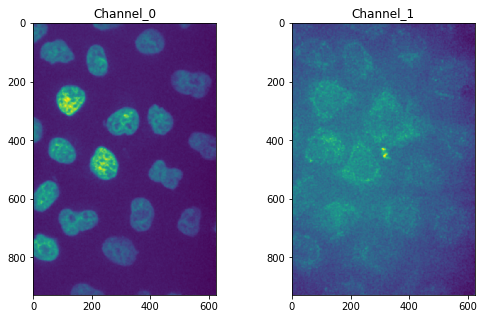

In [7]:
fa.PlotImages (list_images[selected_image],figsize=(8.5, 5) ).plot()

## Cell Segmentation

** TORCH CUDA version installed and working. **
>>>> using GPU


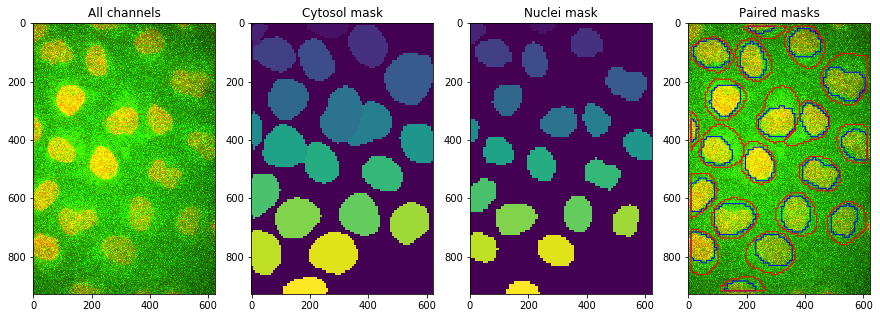

** TORCH CUDA version installed and working. **
>>>> using GPU


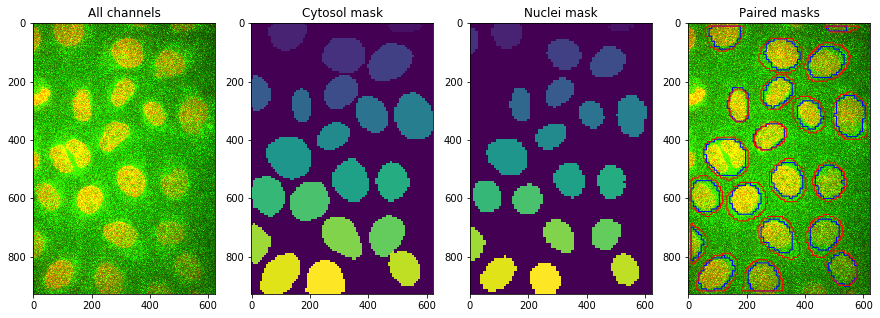

** TORCH CUDA version installed and working. **
>>>> using GPU


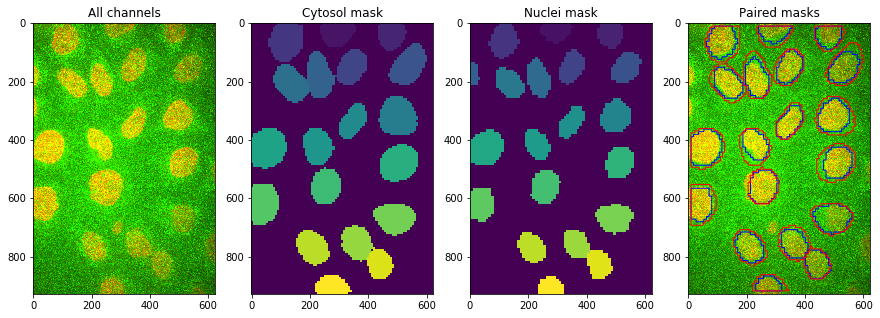

** TORCH CUDA version installed and working. **
>>>> using GPU


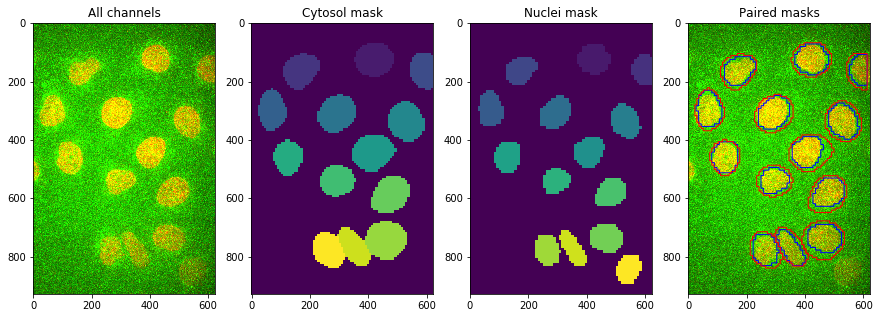

** TORCH CUDA version installed and working. **
>>>> using GPU


In [8]:
for i in range(0,len(list_images)):
    masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, index_paired_masks = fa.CellSegmentation(list_images[i],channels_with_cytosol=channels_with_cytosol, channels_with_nucleus=channels_with_nucleus,diameter_cytosol = diameter_cytosol, diamter_nucleus=diamter_nucleus, show_plot=1).calculate_masks() 

In [ ]:
raise

## Spot Detection

In [ ]:
#[spotDectionCSV, clusterDectionCSV] = fa.BigFISH(list_images[selected_image],channels_with_FISH, voxel_size_z = voxel_size_z,voxel_size_yx = voxel_size_yx,psf_z = psf_z, psf_yx = psf_yx,cluster_radius=cluster_radius,minimum_spots_cluster=minimum_spots_cluster, show_plot=1).detect()

## Extracting data as a dataframe

In [ ]:

#dataframe_FISH = fa.DataProcessing(spotDectionCSV, clusterDectionCSV,masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, dataframe =None).get_dataframe()

In [ ]:
# Spot detection Complete
dataframe_FISH = fa.SpotDetection(list_images[selected_image],channels_with_FISH, voxel_size_z = voxel_size_z,voxel_size_yx = voxel_size_yx,psf_z = psf_z, psf_yx = psf_yx,cluster_radius=cluster_radius,minimum_spots_cluster=minimum_spots_cluster,masks_complete_cells=masks_complete_cells, masks_nuclei=masks_nuclei, masks_cytosol_no_nuclei=masks_cytosol_no_nuclei, show_plot=True).get_dataframe()

In [ ]:
print(set(dataframe_FISH.cell_id.values))
print (len (dataframe_FISH))

In [ ]:
#x3 = np.random.randint(10, size=(4, 4))  # Three-dimensional array
#print(x3)

In [ ]:
#array_selection = (x3[:,0]>=2) & (x3[:,0]<7)
#x3[ array_selection]

In [ ]:
#plt.plot(dataframe_FISH.cell_id.values)

## Accessing data via conditional arguments

In [ ]:
# all clusters in the data
#dataframe_FISH.loc[   (dataframe_FISH['is_nuc']==True) ]
#dataframe_FISH.loc[   (dataframe_FISH['is_cell_fragmented']==True) ]

In [ ]:
# Number of cells
number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==0) ].spot_id) for i in range(0, number_cells)]
# Number of TS per cell
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==0) ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==0)   ].cluster_size.values
# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

# Plotting results

In [ ]:
fig_size = (20, 5)
f = plt.figure(figsize=fig_size)
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=f):

  def normalization_hist (data,numBins=10):
    results, edges = np.histogram(data,bins=numBins, normed=True)
    binWidth = edges[1] - edges[0]
    return edges, results, binWidth
  edges, results, binWidth = normalization_hist (data_to_plot,numBins)
  plt.bar(edges[:-1], results*binWidth, binWidth,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.title(title, size=16)
  return (f)

In [ ]:
#Plotting
fig_size = (25, 5)
f = plt.figure(figsize=fig_size)
# adding subplots
f.add_subplot(1,4,1) 
plot_probability_distribution( number_of_spots_per_cell,   title='Num Spots per cell', xlab='Number', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,2) 
plot_probability_distribution(number_of_TS_per_cell,     title='num TS per cell', xlab='TS per cell', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,3) 
plot_probability_distribution(ts_size,     title='TS size', xlab='RNA per TS', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,4) 
plot_probability_distribution(cell_size  , title='Cell size', xlab='[Pixels]', ylab='Probability', fig=f, color='g')

# plt.savefig('./results/sim_intensity_dist_ch0.png')
plt.show()

# Todo list.

* Add the following columns to the table.
    * is_fragemented
    * spot_type

* Work on the PSF.

* Start working on the processing multiple images